In [1]:
from types import FunctionType
from typing import Callable
from scipy.interpolate import interp1d
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt


@dataclass
class Signal():
    """
    Usage:
    >> Signal([1, 0, 1])(5)
    [1, 0.5, 0, 0.5, 1]

    >> Signal(lambda x: x ** 2)(4)
    [0.0, 0.0626, 0.25, 1.0]

    >> Signal(lambda x: x ** 2, function_input_span=[0, 4])(4)
    [0.0, 1.0, 4.0, 16.0]
    """
    _interval_size: float
    _interpolator: Callable[[list[float]], list[float]]

    def __init__(self,
                 _input: object,
                 interval_size: float=1,
                 function_input_span=[0, 1]):
        self._interval_size = interval_size

        if type(_input) == list or type(_input) == tuple:
            x = [self._interval_size * x_i / (len(_input) - 1)
                 for x_i
                 in range(len(_input))]
            y = _input
            self._interpolator = interp1d(x, y)
        elif isinstance(_input, FunctionType):
            # TODO: take into consideration the interval size and the input span
            # Map [0, `interval_size`] into `function_input_span`
            x_0 = function_input_span[0]
            dt = (function_input_span[1] - x_0)
            f = lambda x: _input(x * dt + x_0)
            self._interpolator = f
        else:
            raise TypeError("Input type not supported")

    def compose_from_list(_input):
        composed_signal = None
        for x in _input:
            s = Signal(x)
            if composed_signal == None:
                composed_signal = s
            else:
                composed_signal += s
        return composed_signal

    def generate(self,
                 samples: int,
                 interval_size: float = None) -> list[float]:
        x_lst = np.linspace(0, 1, samples)
        if interval_size == None:
            x_lst *= self._interval_size
        else:
            x_lst *= interval_size
        return np.array(self._interpolator(x_lst))

    __call__ = generate

    def compose(self, other_signal):
        """

        """
        other_interval = other_signal._interval_size

        new_interval = self._interval_size + other_interval

        def new_interpolator(x_lst: list[float]) -> list[float]:
            if np.isscalar(x_lst):
                return_scalar = True
                x_lst = [x_lst]
            else:
                return_scalar = False

            y_lst = []
            for x in x_lst:
                if x < 0:
                    raise ValueError("Input is outside interpolation range.")
                elif x <= self._interval_size:
                    y_lst.append(self._interpolator(x))
                elif x <= new_interval:
                    y_lst.append(other_signal._interpolator(x - self._interval_size))
                else:
                    raise ValueError("Input is outside interpolation range.")
            if return_scalar:
                return y_lst[0]
            else:
                return y_lst

        new_signal = Signal(new_interpolator, new_interval)
        return new_signal

    def __add__(self, other):
        return self.compose(other)

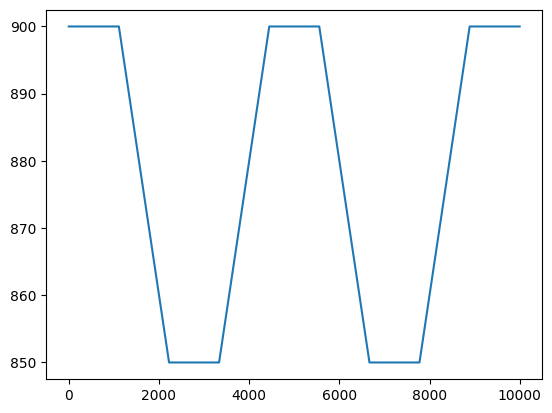

In [2]:
from math import sin, cos, atan2
from random import normalvariate
from tqdm.auto import tqdm


D_in_m = 10 * 1_000
N_x = 10_000
dx = D_in_m / N_x

h_0_in_m = 900
h_lst_in_m = [h_0_in_m]
x_lst = [0.0]
h = h_0_in_m
x = 0.0

h_lst_in_m = Signal([900, 900, 850, 850, 900, 900, 850, 850, 900, 900])(N_x)

for i in range(N_x):
  # h += normalvariate(mu=0.0, sigma = 0.1 * dx)
  x += dx
  # h_lst_in_m.append(h)
  x_lst.append(x)


r_x_lst = x_lst[:-1]

plt.plot(r_x_lst, h_lst_in_m)
plt.show()

In [3]:
from dataclasses import dataclass

@dataclass
class State():
  t: float
  x: float
  v: float
  h: float
  theta: float
  m: float
  P_in: float
  w: float = 0.0
  rho: float = 1.1
  Crr: float = 0.005
  CdA: float = 0.4
  dc_efficiency: float = 0.98
  g: float = 9.7864

  ## Force

  @property
  def F_gravity(self) -> float:
    return  self.m * self.g * sin(self.theta)

  @property
  def F_roll(self) -> float:
    return self.m * self.g * self.Crr * cos(self.theta)

  @property
  def F_aero(self) -> float:
    return (self.CdA / 2) * self.rho * (self.v - self.w) ** 2

  @property
  def F_eff(self) -> float:
    return self.P_eff / self.v

  @property
  def F_out(self) -> float:
    return self.F_gravity + self.F_roll + self.F_aero + self.F_eff

  @property
  def F_in(self) -> float:
    return self.P_in / self.v


  # Power

  @property
  def P_gravity(self) -> float:
    return self.F_gravity * self.v

  @property
  def P_roll(self) -> float:
    return self.F_roll * self.v

  @property
  def P_aero(self) -> float:
    return self.F_aero * self.v

  @property
  def P_eff(self) -> float:
    return self.P_in * (1 - self.dc_efficiency)

  @property
  def P_out(self) -> float:
    return self.F_out * self.v

  @property
  def a(self) -> float:
    return (self.F_in - self.F_out) / self.v

  @property
  def v_in_kph(self) -> float:
    return self.v * 3.6

  @property
  def K(self) -> float:
    return self.m * self.v ** 2 / 2


  @property
  def K_in_kJ(self) -> float:
    return self.K / 1000

In [4]:
from scipy.interpolate import interp1d
h_func = interp1d(r_x_lst, h_lst_in_m)


dt = 0.005
MAX_N_t = 200_000
TARGET_X = 5_000
t_0 = 0.0

initial_state = State(t=0,
                      x=0,
                      v=25/3.6,
                      h=h_0_in_m,
                      theta=0,
                      m=75,
                      P_in=120)


def iterate(curr_state):
  if (curr_state.x + 2 * curr_state.v * dt) > max(r_x_lst):
    return False
  else:

    x_curr = curr_state.x
    x_next = x_curr + curr_state.v * dt
    h_curr = h_func(curr_state.x)
    h_next = h_func(curr_state.x + curr_state.v * dt)

    dx = x_next - x_curr
    dh = h_next - h_curr
    theta = atan2(dh, dx)

    new_state = State(t=curr_state.t + dt,
                      x=x_next,
                      v=curr_state.v + curr_state.a * dt,
                      h=h_next,
                      theta=theta,
                      m=curr_state.m,
                      P_in=curr_state.P_in)

    return new_state


states = [initial_state]
curr_state = states[-1]
for i in (pbar := tqdm(range(MAX_N_t))):
  if i % 5_000 == 0:
    pbar.set_description(f"(t, x) = ({curr_state.t :.2f}, {curr_state.x :.2f}) ")
  curr_state = states[-1]
  curr_state = iterate(curr_state)
  if curr_state == False or curr_state.x > TARGET_X:
    break
  else:
    states.append(curr_state)

print("Done!")

  0%|          | 0/200000 [00:00<?, ?it/s]

Done!


In [5]:
properties_dict = {k: v for k, v in State.__dict__.items() if isinstance(v, property)}

records = []
for s in states:
  properties = {k: getattr(s, k) for k, v in State.__dict__.items() if isinstance(v, property)}
  records.append({**s.__dict__, **properties})


In [6]:
import pandas as pd

df = pd.DataFrame(records)
df['dt'] = df.t.diff()

E_gravity = (df.F_gravity * df.x.diff()).sum() / 1000
E_gravity_up = (df.P_gravity * (df.P_gravity > 0) * df.dt).sum() / 1000
E_gravity_down = -1 * (df.P_gravity * (df.P_gravity < 0) * df.dt).sum() / 1000
E_roll = (df.P_roll * dt).sum() / 1000
E_aero = (df.P_aero * dt).sum() / 1000
E_eff = (df.P_eff * dt).sum() / 1000

E_in = (df.P_in * dt).sum() / 1000

print("--Inflows--")
print(f"{E_in=:.1f}")
print(f"{E_gravity_down=:.1f}")
print("--Outflows--")
print(f"{E_aero=:.1f}")
print(f"{E_roll=:.1f}")
print(f"{E_gravity_up=:.1f}")
print(f"{E_eff=:.1f}")
print("--Misc--")

v_cf_flat = 25 / 3.6
E_aero_cf_flat = df.x.max() * (0.5 * initial_state.CdA * initial_state.rho * (v_cf_flat - initial_state.w) ** 2) / 1000

epsilon = 1 - (E_aero_cf_flat - E_in - E_gravity_down + E_roll + E_gravity_up + E_roll + E_eff) / E_gravity_down
print(f"{E_aero_cf_flat=:.1f}")
print(f"{epsilon=:.2f}")
print(f"{E_gravity=:.1f}")

--Inflows--
E_in=98.7
E_gravity_down=36.7
--Outflows--
E_aero=78.4
E_roll=18.3
E_gravity_up=36.7
E_eff=2.0
--Misc--
E_aero_cf_flat=53.0
epsilon=1.19
E_gravity=-0.0


In [7]:
agg_df = df.rolling(10).mean()

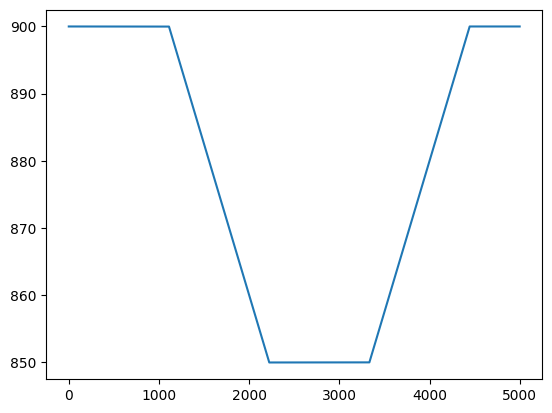

In [8]:
plt.plot(agg_df.x, agg_df.h)

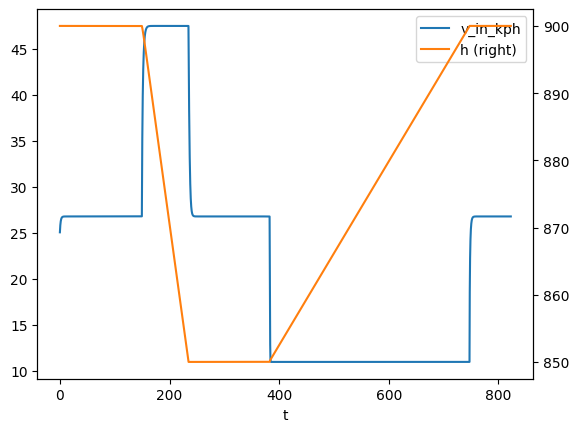

In [9]:
agg_df.plot('t', ['v_in_kph', 'h'], secondary_y=['h'])
plt.show()

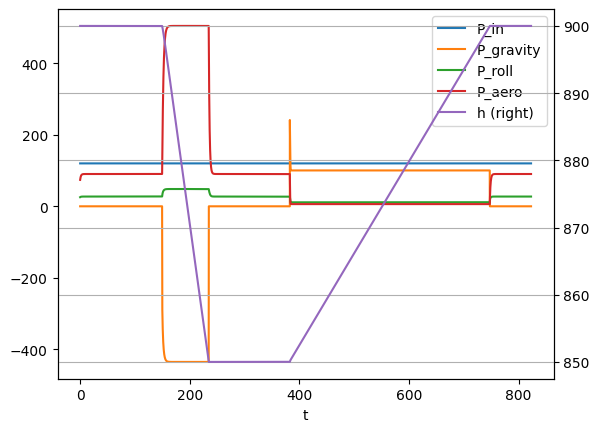

In [10]:
agg_df.plot('t', ['P_in', 'P_gravity', 'P_roll', 'P_aero', 'h'], secondary_y=['h'])
plt.grid()
plt.show()

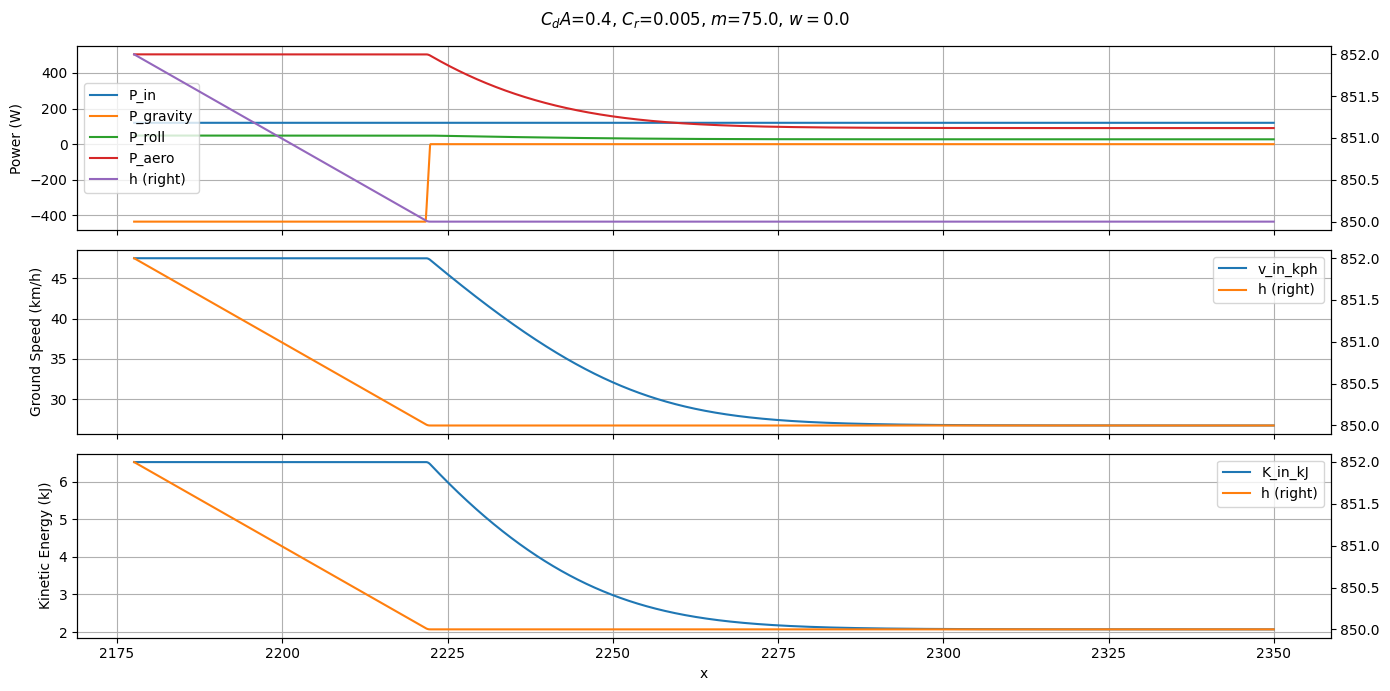

In [11]:

fig_df = agg_df.query("h < 852 & x < 2350")


fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
fig_df.plot('x', ['P_in', 'P_gravity', 'P_roll', 'P_aero', 'h'], secondary_y=['h'], ax=axes[0])
fig_df.plot('x', ['v_in_kph', 'h'], secondary_y=['h'], ax=axes[1])
fig_df.plot('x', ['K_in_kJ', 'h'], secondary_y=['h'], ax=axes[2])

axes[0].set_ylabel('Power (W)')
axes[1].set_ylabel('Ground Speed (km/h)')
axes[2].set_ylabel('Kinetic Energy (kJ)')
axes[0].grid()
axes[1].grid()
axes[2].grid()



plt.suptitle(f"$C_d A$={initial_state.CdA :.2}, $C_r$={initial_state.Crr}, $m$={initial_state.m :.1f}, $w={initial_state.w  * 3.6 :.1f}$")
plt.xlabel('Distance (m)')
# defining display layout
plt.tight_layout()
# show plot
plt.show()

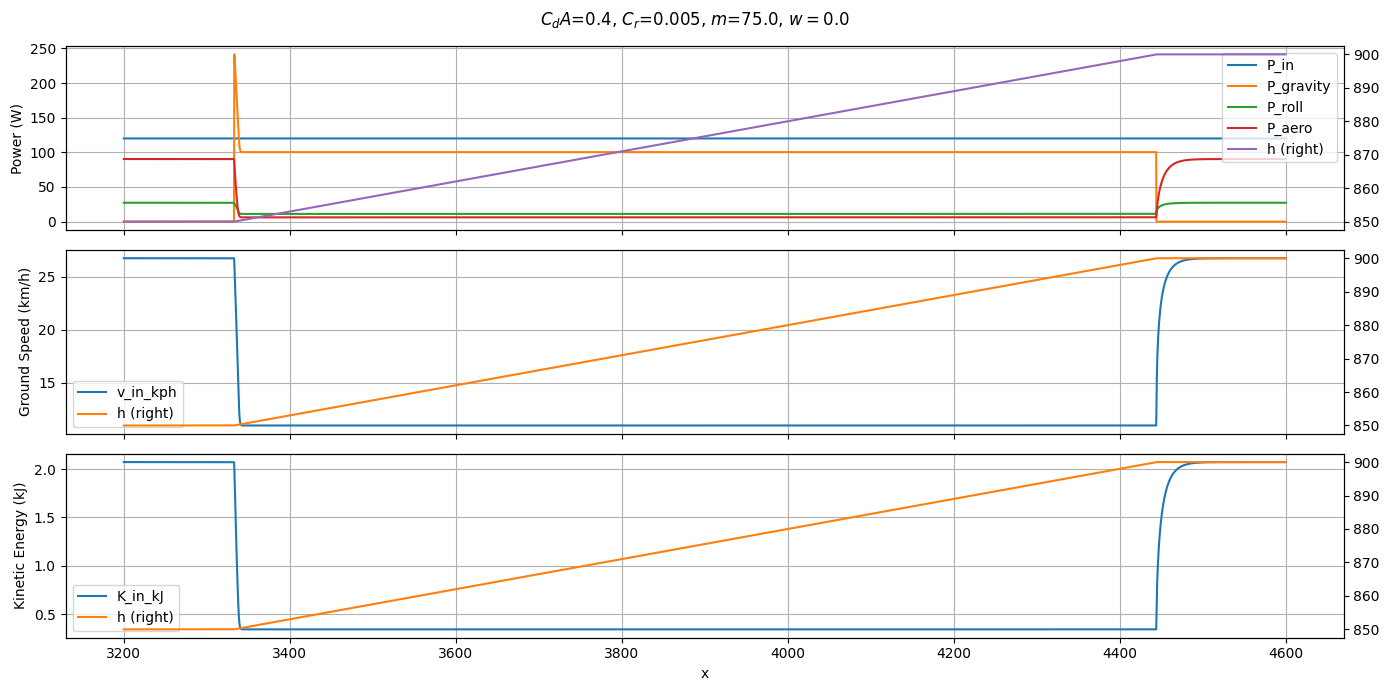

In [12]:

fig_df = agg_df.query("x > 3200 & x < 4600")


fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
fig_df.plot('x', ['P_in', 'P_gravity', 'P_roll', 'P_aero', 'h'], secondary_y=['h'], ax=axes[0])
fig_df.plot('x', ['v_in_kph', 'h'], secondary_y=['h'], ax=axes[1])
fig_df.plot('x', ['K_in_kJ', 'h'], secondary_y=['h'], ax=axes[2])

axes[0].set_ylabel('Power (W)')
axes[1].set_ylabel('Ground Speed (km/h)')
axes[2].set_ylabel('Kinetic Energy (kJ)')
axes[0].grid()
axes[1].grid()
axes[2].grid()



plt.suptitle(f"$C_d A$={initial_state.CdA :.2}, $C_r$={initial_state.Crr}, $m$={initial_state.m :.1f}, $w={initial_state.w  * 3.6 :.1f}$")
plt.xlabel('Distance (m)')
# defining display layout
plt.tight_layout()
# show plot
plt.show()

In [13]:
plt.show()

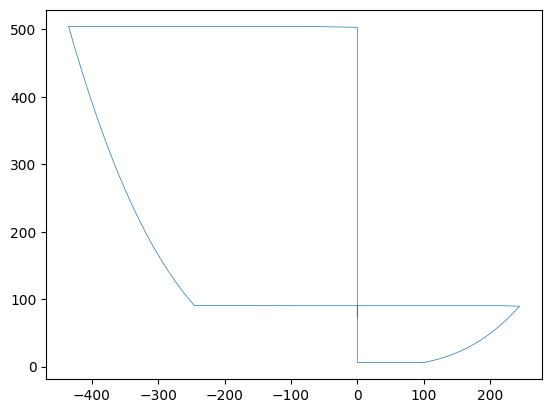

In [14]:
plt.plot(df.P_gravity, df.P_aero, '-', linewidth=0.5)